In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
import joblib

# Define the AI model class
class PomodoroAI:
    def __init__(self):
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.trained = False

    def preprocess_data(self, df: pd.DataFrame):
        df = df.copy()
        df['Date'] = pd.to_datetime(df['Date'])
        recent_cutoff = df['Date'].max() - timedelta(weeks=3)
        df['Weight'] = np.where(df['Date'] >= recent_cutoff, 1.5, 1.0)

        features = ['App Switch Count', 'Distraction Duration (mins)',
                    'Focus Score (0-10)', 'Productivity %']
        target = 'Total Focus Duration (mins)'

        X = df[features]
        y = df[target]
        weights = df['Weight']

        return X, y, weights

    def train(self, df: pd.DataFrame):
        X, y, weights = self.preprocess_data(df)
        self.model.fit(X, y, sample_weight=weights)
        self.trained = True

    def predict(self, app_switches, distraction_minutes, focus_score, productivity_percent):
        if not self.trained:
            raise ValueError("Model is not trained. Call train() first.")

        input_df = pd.DataFrame([{
            'App Switch Count': app_switches,
            'Distraction Duration (mins)': distraction_minutes,
            'Focus Score (0-10)': focus_score,
            'Productivity %': productivity_percent
        }])
        prediction = self.model.predict(input_df)[0]
        return round(prediction, 2)

    def save_model(self, path="pomodoro_model.pkl"):
        joblib.dump(self.model, path)

    def load_model(self, path="pomodoro_model.pkl"):
        self.model = joblib.load(path)
        self.trained = True

# Load your dataset
df = pd.read_excel("realistic_focus_data.xlsx")

# Train and test the model
model = PomodoroAI()
model.train(df)

# Predict an example
suggested = model.predict(app_switches=6, distraction_minutes=10, focus_score=8.0, productivity_percent=85)
print(f"Suggested Pomodoro Duration: {suggested} minutes")


Suggested Pomodoro Duration: 82.64 minutes


In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split data into training and testing
X, y, weights = model.preprocess_data(df)
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)

# Retrain on training set
model.model.fit(X_train, y_train, sample_weight=w_train)

# Predict on test set
y_pred = model.model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("📊 Evaluation Metrics")
print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")
print(f"R² Score: {r2:.2f}")


📊 Evaluation Metrics
Mean Absolute Error (MAE): 15.19 minutes
Root Mean Squared Error (RMSE): 19.84 minutes
R² Score: 0.44


C:\Users\aayuc\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [5]:
df['Focus Ratio'] = df['Total Focus Duration (mins)'] / (
    df['Total Focus Duration (mins)'] + df['Distraction Duration (mins)'] + 1)

df['Focus Score Normalized'] = df['Focus Score (0-10)'] / 10.0


In [7]:
features = [
    'App Switch Count',
    'Distraction Duration (mins)',
    'Focus Score Normalized',
    'Productivity %',
    'Focus Ratio'
]


In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X, y, sample_weight=weights)
best_model = grid_search.best_estimator_

print("Best R² Score from tuning:", grid_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best R² Score from tuning: 0.4821220855140176


In [11]:
model.model = best_model
model.trained = True


In [13]:
# 1. Imports
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib

# 2. Improved Pomodoro AI Class
class PomodoroAIImproved:
    def __init__(self):
        self.model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
        self.trained = False

    def preprocess_data(self, df: pd.DataFrame):
        df = df.copy()
        df['Date'] = pd.to_datetime(df['Date'])
        recent_cutoff = df['Date'].max() - timedelta(weeks=3)
        df['Weight'] = np.where(df['Date'] >= recent_cutoff, 1.5, 1.0)

        # Feature Engineering
        df['Focus Score Normalized'] = df['Focus Score (0-10)'] / 10.0
        df['Focus Ratio'] = df['Total Focus Duration (mins)'] / (
            df['Total Focus Duration (mins)'] + df['Distraction Duration (mins)'] + 1)

        features = [
            'App Switch Count',
            'Distraction Duration (mins)',
            'Focus Score Normalized',
            'Productivity %',
            'Focus Ratio'
        ]
        target = 'Total Focus Duration (mins)'

        X = df[features]
        y = df[target]
        weights = df['Weight']

        return X, y, weights

    def train(self, df: pd.DataFrame):
        X, y, weights = self.preprocess_data(df)
        self.model.fit(X, y, sample_weight=weights)
        self.trained = True

    def predict(self, app_switches, distraction_minutes, focus_score, productivity_percent, focus_ratio=0.75):
        if not self.trained:
            raise ValueError("Model is not trained. Call train() first.")
        input_df = pd.DataFrame([{
            'App Switch Count': app_switches,
            'Distraction Duration (mins)': distraction_minutes,
            'Focus Score Normalized': focus_score / 10.0,
            'Productivity %': productivity_percent,
            'Focus Ratio': focus_ratio
        }])
        prediction = self.model.predict(input_df)[0]
        return round(prediction, 2)

    def save_model(self, path="pomodoro_model_improved.pkl"):
        joblib.dump(self.model, path)

    def load_model(self, path="pomodoro_model_improved.pkl"):
        self.model = joblib.load(path)
        self.trained = True

# 3. Load Data
df = pd.read_excel("realistic_focus_data.xlsx")

# 4. Train and Evaluate the Model
model = PomodoroAIImproved()
X, y, weights = model.preprocess_data(df)

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42)

model.model.fit(X_train, y_train, sample_weight=w_train)
model.trained = True

# 5. Evaluate
y_pred = model.model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("📊 Evaluation Metrics:")
print(f"MAE: {mae:.2f} minutes")
print(f"RMSE: {rmse:.2f} minutes")
print(f"R² Score: {r2:.2f}")

# 6. Example Prediction
suggested_time = model.predict(
    app_switches=5,
    distraction_minutes=10,
    focus_score=8.0,
    productivity_percent=82
)
print(f"🧠 Suggested Pomodoro Duration: {suggested_time} minutes")


📊 Evaluation Metrics:
MAE: 9.59 minutes
RMSE: 14.36 minutes
R² Score: 0.71
🧠 Suggested Pomodoro Duration: 62.76 minutes


C:\Users\aayuc\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [15]:
X, y, weights = model.preprocess_data(df)


In [17]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42)


In [19]:
model.model.fit(X_train, y_train, sample_weight=w_train)


GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [21]:
y_pred = model.model.predict(X_test)


In [23]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


C:\Users\aayuc\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


C:\Users\aayuc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


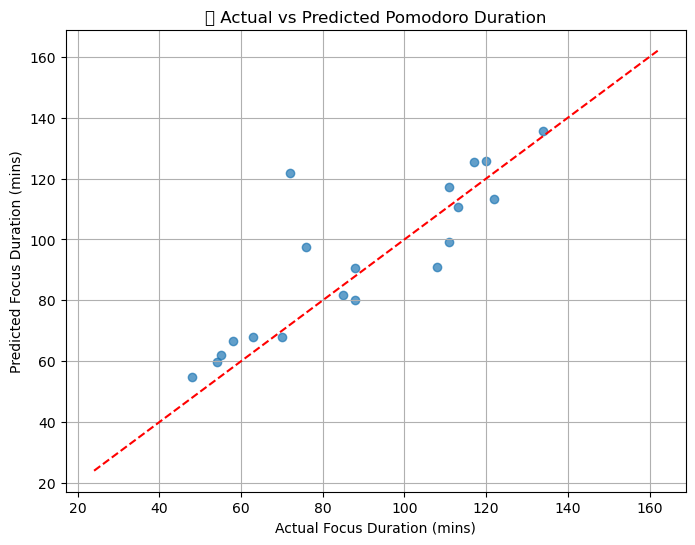

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Focus Duration (mins)")
plt.ylabel("Predicted Focus Duration (mins)")
plt.title("📍 Actual vs Predicted Pomodoro Duration")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # identity line
plt.grid(True)
plt.show()
